In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/sines_2/orig_0_1_2_cnmp/1717886560/'

data_path = root_path + test_path + 'y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')

num_modes = 2
num_demos = Y.shape[0]
num_indiv = Y.shape[0]//num_modes
t_steps = Y.shape[1]

y_min, y_max = np.min(Y), np.max(Y)

Y_means = np.zeros((num_modes,Y.shape[1]))
for i in range(num_modes):
    inds = np.arange(num_indiv)*num_modes+i
    Y_means[i] = np.mean(Y[inds], axis=0)

x: (200,), Y: (128, 200)


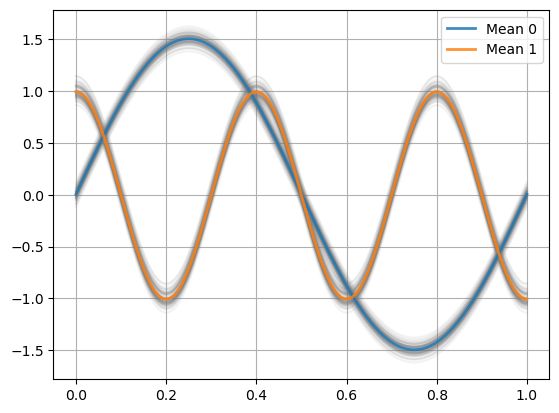

In [3]:
# plot Y and Y_means
plt.plot(x, Y.T, color='gray', alpha=0.1)
for i, traj in enumerate(Y_means):
    plt.plot(x, traj, label=f'Mean {i}', alpha=0.85, linewidth=2)
plt.legend()
plt.grid()
plt.show()

In [4]:
def find_closest_traj_ind(traj, cut=0):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    traj = traj[:-cut] if cut != 0 else traj
    traj_length = traj.shape[0]
    for i, y in enumerate(Y):
        if cut != 0:
            dist = compute_euclidean_dist(y[-traj_length-cut:-cut], traj)  # euclidean distance between two trajectories
        else:
            dist = compute_euclidean_dist(y, traj)
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind, min_dist


def compute_euclidean_dist(traj0, traj1):
    traj_length = traj0.shape[np.argmax(traj0.shape)]
    assert traj_length > 10, f"Trajectory length is too short: {traj_length}"
    
    traj0 = traj0.reshape(traj_length)
    traj1 = traj1.reshape(traj_length)

    dist = np.sum(np.sqrt((traj0 - traj1) ** 2))
    coeff = t_steps/traj_length
    return dist * coeff

In [5]:
model_folder = 'saved_models/'
models_path = f'{root_path}{test_path}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 10, 10
t_steps = Y.shape[1]
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [158,158], decoder_hidden_dims=[158,158], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)

In [6]:
def random_points_on_demo(n):
    rand_x = np.zeros((n, 1))
    rand_y = np.zeros((n, 1))
    for i in range(n):
        rand_ind = np.random.randint(0, t_steps)
        rand_x[i] = x[rand_ind]
        rand_y[i] = Y[np.random.randint(0, num_demos)][rand_ind]
    
    return rand_x, rand_y

def intersection_points_on_demo(n):
    rand_points = np.zeros((n, 2))
    indices = np.zeros(n)

    found = 0
    while found < n:
        rand_ind = np.random.randint(0, t_steps-20) # to avoid the end of the trajectory
        for i in range(num_modes):
            for j in range(num_modes):
                if i==j:
                    continue
                elif np.abs(Y_means[i][rand_ind] - Y_means[j][rand_ind]) < 0.19:
                    if rand_ind in indices:
                        continue
                    else:
                        rand_points[found, 0] = x[rand_ind]
                        rand_points[found, 1] = 0.5 * (Y_means[i][rand_ind] + Y_means[j][rand_ind])
                        indices[found] = rand_ind
                        found += 1

    return rand_points[:, 0].reshape(-1, 1), rand_points[:, 1].reshape(-1, 1), indices.astype(int)

In [7]:
num_tests = 50

# xs, ys, indices = intersection_points_on_demo(num_tests)
# ys = np.clip(ys + (np.random.rand(num_tests, 1)-0.5), y_min, y_max)
# print(xs)
# print(ys)
# for i in indices:
#     print(i, end=',')


xs = np.array([[0.45728643],
 [0.06532663],
 [0.6281407 ],
 [0.38693467],
 [0.47236181],
 [0.05025126],
 [0.59798995],
 [0.51256281],
 [0.52261307],
 [0.61809045],
 [0.6080402 ],
 [0.60301508],
 [0.44723618],
 [0.57788945],
 [0.49246231],
 [0.05527638],
 [0.53266332],
 [0.54271357],
 [0.61306533],
 [0.48241206],
 [0.58291457],
 [0.46231156],
 [0.47738693],
 [0.50251256],
 [0.3919598 ],
 [0.3718593 ],
 [0.63316583],
 [0.59296482],
 [0.52763819],
 [0.4120603 ],
 [0.44221106],
 [0.46733668],
 [0.50753769],
 [0.40703518],
 [0.07035176],
 [0.41708543],
 [0.39698492],
 [0.53768844],
 [0.49748744],
 [0.40201005],
 [0.51758794],
 [0.62311558],
 [0.54773869],
 [0.06030151],
 [0.38190955],
 [0.4321608 ],
 [0.5879397 ],
 [0.48743719],
 [0.45226131],
 [0.43718593]])

ys = np.array([[ 0.52951149],
 [ 0.33682044],
 [-0.72971974],
 [ 1.1504322 ],
 [ 0.33100074],
 [ 0.70071713],
 [-1.10932198],
 [ 0.01476378],
 [-0.42503729],
 [-0.91740923],
 [-1.07061046],
 [-0.73548348],
 [ 0.44460116],
 [-0.89839394],
 [ 0.21928794],
 [ 0.32252601],
 [-0.31217497],
 [-0.44934838],
 [-1.17524189],
 [ 0.40454362],
 [-1.13701791],
 [ 0.52194043],
 [ 0.11680082],
 [ 0.14426154],
 [ 1.10841302],
 [ 0.82633791],
 [-1.17252156],
 [-1.01425457],
 [-0.265736  ],
 [ 1.1971885 ],
 [ 0.67316359],
 [ 0.32856624],
 [-0.05343452],
 [ 0.75168203],
 [ 0.4014307 ],
 [ 0.64014697],
 [ 1.01138727],
 [-0.54758401],
 [ 0.06648761],
 [ 0.84843144],
 [-0.26357272],
 [-1.11206156],
 [-0.57481936],
 [ 0.70499575],
 [ 0.99958533],
 [ 0.54636608],
 [-0.66226392],
 [ 0.05174192],
 [ 0.39885031],
 [ 0.85368706]])
indices = np.array([91,13,125,77,94,10,119,102,104,123,121,120,89,115,98,11,106,108,122,96,116,92,95,100,78,74,
                    126,118,105,82,88,93,101,81,14,83,79,107,99,80,103,124,109,12,76,86,117,97,90,87])


In [8]:
import pickle

with open('rand_bimodal_smp_3_types.pkl', 'rb') as f:
    smp_trajs = pickle.load(f)

In [10]:
from tqdm import tqdm
import seaborn as sns

from matplotlib.lines import Line2D

dark_gray = '#4d4d4d'

colors = [sns.color_palette('tab10')[8], sns.color_palette('tab10')[3], 
          sns.color_palette('tab10')[0], sns.color_palette('tab10')[4], 
          sns.color_palette('tab10')[1]]

# linestyles = [(5, (7, 2)), (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]
linestyles = [(0, (3, 1, 1, 1, 1, 1)), '--', ':', '-.', '-']

y1s = Y_means[:, -1]

num_models = 9
# 1: ProMP, 2: GMR, 3: CNMP, 4: StableMP, 5:CNEP, 6: CNEP-MoE, 7: CNEP-A0, 8: CNEP-A1, 9: CNEP-A2

euc_errors = np.zeros((num_tests*num_modes, num_models))

plot_id = 7

for i1 in range(num_modes):
    for i0 in tqdm(range(num_tests)):
        plot_id = i0

        p = ProMP(n_dims=1, n_weights_per_dim=10)
        p.imitate(np.tile(x, (num_demos, 1)), Y)

        input_data = x.reshape(-1, 1)  # Phase variable as a column vector

        priors = 20  # Number of GMM components
        gmr_model = GMM(n_components=priors, random_state=1234)
        gmr_model.from_samples(Y)

        x0 = xs[i0]
        y0 = ys[i0]
        y1 = y1s[i1]

        # ProMP
        p = p.condition_position(y0, t=x0).condition_position(y1, t=1)
        trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

        # GMR
        gmr_model_ = gmr_model.condition([indices[i0], -1], [y0[0], y1])
        trajectory_g = gmr_model_.sample(1)
        trajectory_g = np.insert(trajectory_g, indices[i0], y0[0])
        trajectory_g = np.append(trajectory_g, y1)

        # CNMP and CNEP
        val_obs[0, :2, :dx] = torch.tensor([x0[0], 1]).unsqueeze(1)
        val_obs[0, :2, dx:] = torch.tensor([y0[0], y1]).unsqueeze(1)

        with torch.no_grad():
            trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
            pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
            dec_id = torch.argmax(gate.squeeze(1), dim=-1)
            trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

            confs = gate.view(2, 1, 1, 1)
            preds = pred_cnep[:, :, :, :dy]

            weighted_preds = preds * confs  # Element-wise multiplication, shape (num_gates, 1, 200, 1)
            trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

            pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
            dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
            trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

            pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
            dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
            trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

            pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
            dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
            trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]


        for j in range(num_models):
            if j == 0:
                traj = trajectory_p.squeeze(0)
                if i0 == plot_id:
                    plt.plot(x, traj, color=colors[j], label='ProMP', linewidth=2.5, linestyle=linestyles[j])
            elif j == 1:
                traj = trajectory_g
                if i0 == plot_id:
                    plt.plot(x, traj, color=colors[j], label='GMM-GMR', linewidth=2.5, linestyle=linestyles[j])
            elif j == 2:
                traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
                if i0 == plot_id:
                    plt.plot(x, traj, color=colors[j], label='CNMP', linewidth=2.5, linestyle=linestyles[j])
            elif j == 3:  # offline test
                traj = smp_trajs[i1*num_tests+i0]
                if i0 == plot_id:
                    plt.plot(x[indices[i0]:], traj, color=colors[j], label='Stable MP', linewidth=2.5, linestyle=linestyles[j])
            elif j == 4:
                traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
                if i0 == plot_id:
                    plt.plot(x, traj, color=colors[j], label='CNEP', linewidth=2.5, linestyle=linestyles[j])
            elif j == 5:
                traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
            elif j == 6:
                traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
            elif j == 7:
                traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
            elif j == 8:
                traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

            cut = 0
            if j == 3:
                cut = 2

            closest_traj_ind, closest_dist = find_closest_traj_ind(traj, cut)
            euc_errors[i0, j] = closest_dist / t_steps

        if i0 == plot_id:
            plt.ylim(y_min-0.1, y_max+0.1)
            plt.title('Trajectory Generation', fontsize=14, fontweight='bold')
            plt.xlabel('Time', fontsize=12, fontweight='bold')
            plt.ylabel('Position', fontsize=12, fontweight='bold')
            plt.plot(x, Y.T, color='gray', alpha=0.02)
            plt.scatter(x0, y0, color='black', marker='*', s=100, label='Conditioning Point', zorder=10)
            plt.scatter(1, y1, color='black', marker='*', s=100, label='Conditioning Point', zorder=10)

            handles = [Line2D([0], [0], color=dark_gray, lw=2, alpha=0.5, label='Demonstration')] + plt.gca().get_legend_handles_labels()[0]

            plt.legend(handles=handles, fontsize=11, loc='upper right', frameon=True, framealpha=0.9, prop=dict(weight='bold'))
            plt.grid()
            plt.tight_layout()
            plt.savefig(f'plots/bi_out/bimodal_comparison_{i0}_mode_{i1}.svg', format='svg', dpi=300)
            plt.clf()

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [13:41<01:53, 22.72s/it]

In [ ]:
# print mean errors and standard deviations
# print('RMSE')
# print(np.mean(rmse_errors, axis=0))
# print(np.std(rmse_errors, axis=0))
# print('MAE')
# print(np.mean(mae_errors, axis=0))
# print(np.std(mae_errors, axis=0))
# print('Max error')
# print(np.mean(max_errors, axis=0))
# print(np.std(max_errors, axis=0))

print('Euc error')
print(np.mean(euc_errors, axis=0))
print(np.std(euc_errors, axis=0))

Euc error
[0.07258712 0.44832968 0.37903327 0.15327317 0.10322149 0.11296915
 0.18532803 0.06876199 0.49652562]
[0.05108068 0.27518982 0.03452802 0.16554859 0.05562196 0.0647586
 0.17238755 0.05661674 0.03971803]


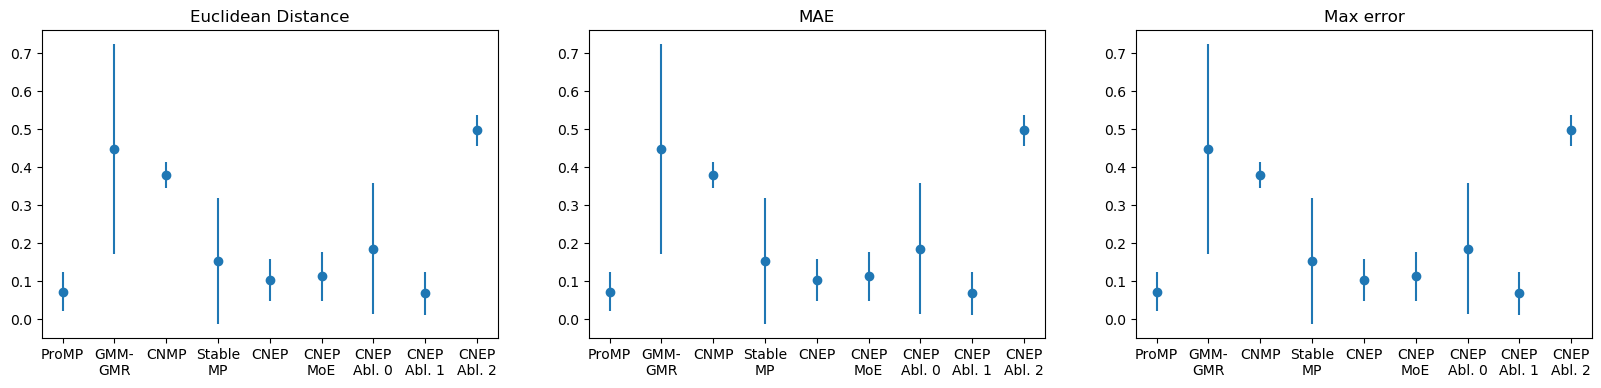

In [ ]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['ProMP', 'GMM-\nGMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[0].set_title('Euclidean Distance')
ax[1].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()
# plt.savefig('table2_0.png')

# fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# # x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
# x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP']
# ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
# ax[0].set_title('RMSE')
# ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
# ax[1].set_title('MAE')
# ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
# ax[2].set_title('Max error')
# plt.show()

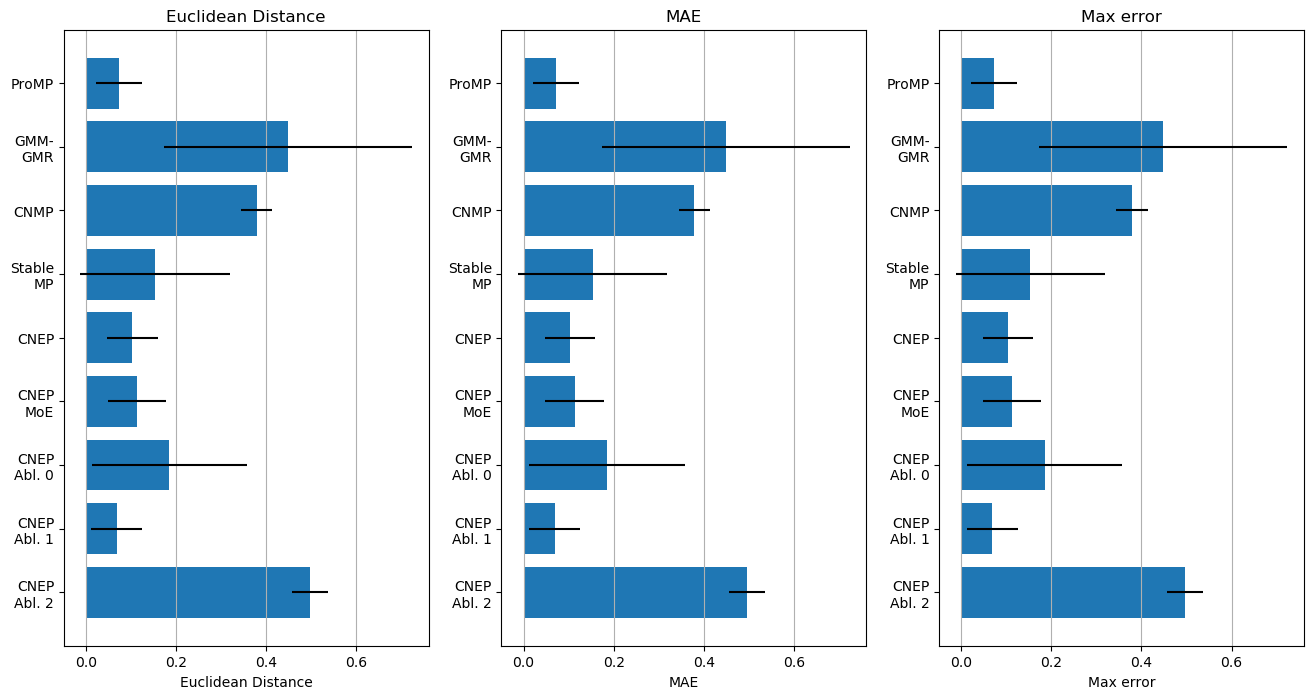

In [ ]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('Euclidean Distance')
ax[0].set_title('Euclidean Distance')
ax[1].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()
# plt.savefig('table2_1.png')